# OVERVIEW

In this section, we will optimize our model by tuning our hyperparameter. The model that will be tuned is Extreme Gradient Boosting. Because, XGBoost have good evaluation metrics. The parameter that will be tuned are:
1. Number of Tree (n_estimators)
2. Maximum of Tree (max_depth)
3. Minimum Sample in Leaf (min_child_weight)
4. Gamma (gamma)
5. Number of Data for Bootstrap (subsample)
6. Maximum Feature in Percent (colsample_bytree)
7. Coeficient for Lasso (reg_alpha)
8. Coeficient for Ridge (reg_lambda)
9. Learning Rate (learning_rate)

# IMPORT LIBRARY

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [40]:
df_main = pd.read_csv('CLEAN DATASET.csv')
df_main = df_main.drop(['bank_id'],axis=1)
df_main = pd.get_dummies(df_main)

# SPLITTING ORIGINAL DATASET AND VALIDATION DATASET

In [41]:
df_train = df_main[:26315]
df_test = df_main[26315:]

In [42]:
X = df_train.drop(['DELQ_FLG'],1)
y = df_train['DELQ_FLG']
X_valid = df_test.drop(['DELQ_FLG'],1)

# SPLITTING TRAINING AND TESTING DATASET

In [50]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.3,stratify=y,random_state=123)

In [51]:
X_train.head()

,AGE,DEPENDENT_CNT,SA_AVG_BAL,SA_CNT,CC_CNT,HP_CNT,TL_CNT,TLi_CNT,INS_CREDIT_LIFE_CNT,INS_LIFE_CNT,...,OCC_DESC_MANAGER OR SUPERVISOR,OCC_DESC_NON-EXECUTIVE,OCC_DESC_OTHERS,OCC_DESC_PROFESSIONAL,OCC_DESC_RETIRED,OCC_DESC_SELF EMPLOYED,OCC_DESC_STUDENT,CUST_SEGMENT_MASS,CUST_SEGMENT_PREFERRED,CUST_SEGMENT_PRIME
11700,34,0.0,1553.232258,1.0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0
373,54,0.0,7133.668387,1.0,2,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
12338,33,0.0,8591.495484,2.0,2,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
4831,42,0.0,701.461290,1.0,2,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
15914,31,1.0,153.199677,1.0,0,0,0,0,1,0,...,0,0,1,0,0,0,0,1,0,0


In [52]:
X_train = np.asmatrix(X_train)
X_test = np.asmatrix(X_test)

________

______________

In [27]:
from imblearn.pipeline import Pipeline
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import StratifiedKFold,GridSearchCV
from sklearn.feature_selection import SelectFromModel

In [28]:
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter 

# Eval Metrics

In [29]:
# library untuk evaluasi hasil prediksi
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.metrics import geometric_mean_score
from sklearn.metrics import make_scorer,precision_score
from sklearn.metrics import recall_score,accuracy_score,f1_score

# library untuk menghitung skor validasi silang
from sklearn.model_selection import cross_val_score

# library untuk melakukan validasi silang secara berstrata
from sklearn.model_selection import StratifiedKFold

In [30]:
def geometri_score(y_true,y_pred):
    from sklearn.metrics import confusion_matrix
    spe = confusion_matrix(y_true,y_pred)[0,0]/(confusion_matrix(y_true,y_pred)[0,0]+confusion_matrix(y_true,y_pred)[0,1])
    sen = recall_score(y_true,y_pred)
    acc = accuracy_score(y_true,y_pred)
    eval_baru = (spe*sen*acc)**(1/3)
    return eval_baru

geometri = make_scorer(geometri_score)

In [31]:
from sklearn.metrics import make_scorer,precision_score,recall_score,accuracy_score,auc
scorers = {
    'precision_score':make_scorer(precision_score),
    'recall_score':make_scorer(recall_score),
    'accuracy_score':make_scorer(accuracy_score),
    'auc':make_scorer(auc),
    'geometric_mean_score': make_scorer(geometri_score)
}
print(scorers)

{'precision_score': make_scorer(precision_score), 'recall_score': make_scorer(recall_score), 'accuracy_score': make_scorer(accuracy_score), 'auc': make_scorer(auc), 'geometric_mean_score': make_scorer(geometri_score)}


In [22]:
# menegmbangkan fungsi untuk evaluasi

skf = StratifiedKFold(n_splits=5,random_state=10)

def eval_cv(alg,X,y):
    print("akurasi cv : \n",
          cross_val_score(alg,X,y,scoring="accuracy",cv=skf),"\n",
          cross_val_score(alg,X,y,scoring="accuracy",cv=skf).mean(),"\n")
    print("recall cv : \n",
          cross_val_score(alg,X,y,scoring="recall",cv=skf),"\n",
          cross_val_score(alg,X,y,scoring="recall",cv=skf).mean(),"\n")
    print("presisi cv : \n",
          cross_val_score(alg,X,y,scoring="precision",cv=skf),"\n",
          cross_val_score(alg,X,y,scoring="precision",cv=skf).mean(),"\n")
    print("f1 cv : \n",
          cross_val_score(alg,X,y,scoring="f1",cv=skf),"\n",
          cross_val_score(alg,X,y,scoring="f1",cv=skf).mean(),"\n")

    
def eval(alg,X,y):
    alg.fit(X_train,y_train)
    print("akurasi:\n",
          accuracy_score(y,alg.predict(X)),"\n")
    print("confusion matirx test:\n",
          confusion_matrix(y,alg.predict(X)),"\n")
    print("classification Report test:\n",
          classification_report(y,alg.predict(X)),"\n")

________________

In [34]:
exgb_tune = XGBClassifier(min_child_weight=1,
                    max_depth=5,
                    gamma=0.12,
                    subsample=0.8,
                    colsample_bytree=1,
                    learning_rate=0.8,
                    #n_estimators=1000,
                    random_state=123)

pipe_exgb_tune = Pipeline([('imb',RandomUnderSampler(random_state=123)),('clf',exgb_tune)])

In [20]:
eval_cv(pipe_exgb_tune,X_train,y_train)

akurasi cv : 
 [ 0.8990228   0.89793702  0.8965798   0.90010858  0.89956569] 
 0.898642779587 

recall cv : 
 [ 0.0704698   0.06375839  0.05033557  0.09395973  0.04697987] 
 0.0651006711409 

presisi cv : 
 [ 0.18103448  0.1637931   0.13274336  0.22222222  0.14      ] 
 0.167958634252 

f1 cv : 
 [ 0.10144928  0.09178744  0.0729927   0.13207547  0.07035176] 
 0.0937313292396 



In [35]:
eval(pipe_exgb_tune,X_test,y_test)

akurasi:
 0.619506016466 

confusion matirx test:
 [[4500 2757]
 [ 247  391]] 

classification Report test:
              precision    recall  f1-score   support

        0.0       0.95      0.62      0.75      7257
        1.0       0.12      0.61      0.21       638

avg / total       0.88      0.62      0.71      7895
 



# Tunning 1

In [67]:
rus = RandomUnderSampler(random_state=123)

# model yang disiapkan
exgb_tune = XGBClassifier(min_child_weight=1,
                    max_depth=5,
                    gamma=0.1,
                    subsample=0.8,
                    colsample_bytree=1,
                    learning_rate=0.5,
                    #n_estimators=1000,
                    random_state=123)

select = SelectFromModel(exgb_tune,threshold='median')
pipe_exgb = Pipeline([('rus',rus),('select',select),('clf',exgb_tune)])

# parameter yang disiapkan
param_gb = {
    'clf__n_estimators':[20,40,60,100,120,140]}

skf = StratifiedKFold(n_splits=5,random_state=123)

exgb_grid = GridSearchCV(pipe_exgb,
                       param_grid=param_gb,
                       # ukuran prediksi yang digunakan untuk tunning
                       refit = 'geometric',
                       # metode validasi silang
                       cv=skf)

exgb_grid.fit(X_train,y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=123, shuffle=False),
       error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('rus', RandomUnderSampler(random_state=123, ratio='auto', replacement=False,
          return_indices=False)), ('select', SelectFromModel(estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0.1, learning_rate=0.5, max_delta_step=0,
...=123, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=0.8))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'clf__n_estimators': [20, 40, 60, 100, 120, 140]},
       pre_dispatch='2*n_jobs', refit='geometric', return_train_score=True,
       scoring=None, verbose=0)

In [69]:
print(exgb_grid.best_params_)
print(exgb_grid.best_score_)
eval(exgb_grid.best_estimator_,X_test,y_test)

{'clf__n_estimators': 60}
0.620901194354
akurasi:
 0.611019632679 

confusion matirx test:
 [[4399 2858]
 [ 213  425]] 

classification Report test:
              precision    recall  f1-score   support

        0.0       0.95      0.61      0.74      7257
        1.0       0.13      0.67      0.22       638

avg / total       0.89      0.61      0.70      7895
 



# Tunning 2

In [73]:
rus = RandomUnderSampler(random_state=123)

# model yang disiapkan
exgb_tune2 = XGBClassifier(#min_child_weight=1,
                    #max_depth=5,
                    gamma=0.1,
                    subsample=0.8,
                    colsample_bytree=1,
                    learning_rate=0.5,
                    n_estimators=60,
                    random_state=123)

select = SelectFromModel(exgb_tune2,threshold='median')
pipe_exgb2 = Pipeline([('rus',rus),('select',select),('clf',exgb_tune2)])

# parameter yang disiapkan
param_gb2 = {
    'clf__max_depth':range(3,10,2),
    'clf__min_child_weight':range(1,6,2)
}

skf = StratifiedKFold(n_splits=5,random_state=123)

exgb_grid2 = GridSearchCV(pipe_exgb2,
                       param_grid=param_gb2,
                       # ukuran prediksi yang digunakan untuk tunning
                       refit = 'geometric',
                       # metode validasi silang
                       cv=skf)

exgb_grid2.fit(X_train,y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=123, shuffle=False),
       error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('rus', RandomUnderSampler(random_state=123, ratio='auto', replacement=False,
          return_indices=False)), ('select', SelectFromModel(estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0.1, learning_rate=0.5, max_delta_step=0,
...=123, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=0.8))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'clf__max_depth': range(3, 10, 2), 'clf__min_child_weight': range(1, 6, 2)},
       pre_dispatch='2*n_jobs', refit='geometric', return_train_score=True,
       scoring=None, verbose=0)

In [74]:
print(exgb_grid2.best_params_)
print(exgb_grid2.best_score_)
eval(exgb_grid2.best_estimator_,X_test,y_test)

{'clf__max_depth': 9, 'clf__min_child_weight': 5}
0.62671009772
akurasi:
 0.621405953135 

confusion matirx test:
 [[4471 2786]
 [ 203  435]] 

classification Report test:
              precision    recall  f1-score   support

        0.0       0.96      0.62      0.75      7257
        1.0       0.14      0.68      0.23       638

avg / total       0.89      0.62      0.71      7895
 



# Tunning 3

In [75]:
rus = RandomUnderSampler(random_state=123)

# model yang disiapkan
exgb_tune3 = XGBClassifier(#min_child_weight=1,
                    #max_depth=5,
                    gamma=0.1,
                    subsample=0.8,
                    colsample_bytree=1,
                    learning_rate=0.5,
                    n_estimators=60,
                    random_state=123)

select = SelectFromModel(exgb_tune3,threshold='median')
pipe_exgb3 = Pipeline([('rus',rus),('select',select),('clf',exgb_tune3)])

# parameter yang disiapkan
param_gb3 = {
    'clf__max_depth':[8,9,10],
    'clf__min_child_weight':[4,5,6]
}

skf = StratifiedKFold(n_splits=5,random_state=123)

exgb_grid3 = GridSearchCV(pipe_exgb3,
                       param_grid=param_gb3,
                       # ukuran prediksi yang digunakan untuk tunning
                       refit = 'geometric',
                       # metode validasi silang
                       cv=skf)

exgb_grid3.fit(X_train,y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=123, shuffle=False),
       error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('rus', RandomUnderSampler(random_state=123, ratio='auto', replacement=False,
          return_indices=False)), ('select', SelectFromModel(estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0.1, learning_rate=0.5, max_delta_step=0,
...=123, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=0.8))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'clf__max_depth': [8, 9, 10], 'clf__min_child_weight': [4, 5, 6]},
       pre_dispatch='2*n_jobs', refit='geometric', return_train_score=True,
       scoring=None, verbose=0)

In [76]:
print(exgb_grid3.best_params_)
print(exgb_grid3.best_score_)
eval(exgb_grid3.best_estimator_,X_test,y_test)

{'clf__max_depth': 10, 'clf__min_child_weight': 5}
0.628555917481
akurasi:
 0.623559214693 

confusion matirx test:
 [[4497 2760]
 [ 212  426]] 

classification Report test:
              precision    recall  f1-score   support

        0.0       0.95      0.62      0.75      7257
        1.0       0.13      0.67      0.22       638

avg / total       0.89      0.62      0.71      7895
 



# Tunning 4

In [77]:
rus = RandomUnderSampler(random_state=123)

# model yang disiapkan
exgb_tune4 = XGBClassifier(min_child_weight=5,
                    max_depth=10,
                    #gamma=0.1,
                    subsample=0.8,
                    colsample_bytree=1,
                    learning_rate=0.5,
                    n_estimators=60,
                    random_state=123)

select = SelectFromModel(exgb_tune4,threshold='median')
pipe_exgb4 = Pipeline([('rus',rus),('select',select),('clf',exgb_tune4)])

# parameter yang disiapkan
param_gb4 = {
    'clf__gamma':[8.5,0.6,0.7,0.8,0.9,1]
}

skf = StratifiedKFold(n_splits=5,random_state=123)

exgb_grid4 = GridSearchCV(pipe_exgb4,
                       param_grid=param_gb4,
                       # ukuran prediksi yang digunakan untuk tunning
                       refit = 'geometric',
                       # metode validasi silang
                       cv=skf)

exgb_grid4.fit(X_train,y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=123, shuffle=False),
       error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('rus', RandomUnderSampler(random_state=123, ratio='auto', replacement=False,
          return_indices=False)), ('select', SelectFromModel(estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.5, max_delta_step=0,
  ...=123, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=0.8))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'clf__gamma': [8.5, 0.6, 0.7, 0.8, 0.9, 1]},
       pre_dispatch='2*n_jobs', refit='geometric', return_train_score=True,
       scoring=None, verbose=0)

In [78]:
print(exgb_grid4.best_params_)
print(exgb_grid4.best_score_)
eval(exgb_grid4.best_estimator_,X_test,y_test)

{'clf__gamma': 0.7}
0.628501628664
akurasi:
 0.617606079797 

confusion matirx test:
 [[4460 2797]
 [ 222  416]] 

classification Report test:
              precision    recall  f1-score   support

        0.0       0.95      0.61      0.75      7257
        1.0       0.13      0.65      0.22       638

avg / total       0.89      0.62      0.70      7895
 



# Tunning 5

In [81]:
rus = RandomUnderSampler(random_state=123)

# model yang disiapkan
exgb_tune5 = XGBClassifier(min_child_weight=5,
                    max_depth=10,
                    gamma=0.7,
                    #subsample=0.8,
                    #colsample_bytree=1,
                    learning_rate=0.5,
                    n_estimators=60,
                    random_state=123)

select = SelectFromModel(exgb_tune5,threshold='median')
pipe_exgb5 = Pipeline([('rus',rus),('select',select),('clf',exgb_tune5)])

# parameter yang disiapkan
param_gb5 = {
      'clf__subsample':[i/10.0 for i in range(6,10)],
      'clf__colsample_bytree':[i/10 for i in range(6,10)]+[1]
}

skf = StratifiedKFold(n_splits=5,random_state=123)

exgb_grid5 = GridSearchCV(pipe_exgb5,
                       param_grid=param_gb5,
                       # ukuran prediksi yang digunakan untuk tunning
                       refit = 'geometric',
                       # metode validasi silang
                       cv=skf)

exgb_grid5.fit(X_train,y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=123, shuffle=False),
       error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('rus', RandomUnderSampler(random_state=123, ratio='auto', replacement=False,
          return_indices=False)), ('select', SelectFromModel(estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0.7, learning_rate=0.5, max_delta_step=0,
...te=123, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'clf__subsample': [0.6, 0.7, 0.8, 0.9], 'clf__colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1]},
       pre_dispatch='2*n_jobs', refit='geometric', return_train_score=True,
       scoring=None, verbose=0)

In [82]:
print(exgb_grid5.best_params_)
print(exgb_grid5.best_score_)
eval(exgb_grid5.best_estimator_,X_test,y_test)

{'clf__colsample_bytree': 0.6, 'clf__subsample': 0.8}
0.629533116178
akurasi:
 0.614312856238 

confusion matirx test:
 [[4467 2790]
 [ 255  383]] 

classification Report test:
              precision    recall  f1-score   support

        0.0       0.95      0.62      0.75      7257
        1.0       0.12      0.60      0.20       638

avg / total       0.88      0.61      0.70      7895
 



# Tunning 6

In [83]:
rus = RandomUnderSampler(random_state=123)

# model yang disiapkan
exgb_tune6 = XGBClassifier(min_child_weight=5,
                    max_depth=10,
                    gamma=0.7,
                    subsample=0.8,
                    colsample_bytree=0.6,
                    learning_rate=0.5,
                    n_estimators=60,
                    random_state=123)

select = SelectFromModel(exgb_tune6,threshold='median')
pipe_exgb6 = Pipeline([('rus',rus),('select',select),('clf',exgb_tune6)])

# parameter yang disiapkan
param_gb6 = {
    'clf__reg_alpha':[0.01,0.1,0,1,10],
    'clf__reg_lambda':[0.01,0.1,0,1,10]}

skf = StratifiedKFold(n_splits=5,random_state=123)

exgb_grid6 = GridSearchCV(pipe_exgb6,
                       param_grid=param_gb6,
                       # ukuran prediksi yang digunakan untuk tunning
                       refit = 'geometric',
                       # metode validasi silang
                       cv=skf)

exgb_grid6.fit(X_train,y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=123, shuffle=False),
       error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('rus', RandomUnderSampler(random_state=123, ratio='auto', replacement=False,
          return_indices=False)), ('select', SelectFromModel(estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.6, gamma=0.7, learning_rate=0.5,
       max_delta...eg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=0.8))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'clf__reg_alpha': [0.01, 0.1, 0, 1, 10], 'clf__reg_lambda': [0.01, 0.1, 0, 1, 10]},
       pre_dispatch='2*n_jobs', refit='geometric', return_train_score=True,
       scoring=None, verbose=0)

In [84]:
print(exgb_grid6.best_params_)
print(exgb_grid6.best_score_)
eval(exgb_grid6.best_estimator_,X_test,y_test)

{'clf__reg_alpha': 1, 'clf__reg_lambda': 10}
0.631541802389
akurasi:
 0.62457251425 

confusion matirx test:
 [[4511 2746]
 [ 218  420]] 

classification Report test:
              precision    recall  f1-score   support

        0.0       0.95      0.62      0.75      7257
        1.0       0.13      0.66      0.22       638

avg / total       0.89      0.62      0.71      7895
 



# Tunning 7 : Robustnes

In [91]:
rus = RandomUnderSampler(random_state=123)

# model yang disiapkan
exgb_tune7 = XGBClassifier(min_child_weight=5,
                    max_depth=10,
                    gamma=0.7,
                    subsample=0.8,
                    colsample_bytree=0.6,
                    #learning_rate=0.5,
                    #n_estimators=60,
                    reg_alpha=1,
                    reg_lambda=10,
                    random_state=123)

select = SelectFromModel(exgb_tune7,threshold='median')
pipe_exgb7 = Pipeline([('rus',rus),('select',select),('clf',exgb_tune7)])

# parameter yang disiapkan
param_gb7 = [
    {'clf__learning_rate':[0.5],'clf__n_estimators':[60]},
    {'clf__learning_rate':[0.25],'clf__n_estimators':[120]},
    {'clf__learning_rate':[0.2],'clf__n_estimators':[150]},
    {'clf__learning_rate':[0.1],'clf__n_estimators':[300]},
    {'clf__learning_rate':[0.05],'clf__n_estimators':[600]}
]


skf = StratifiedKFold(n_splits=5,random_state=123)

exgb_grid7 = GridSearchCV(pipe_exgb7,
                       param_grid=param_gb7,
                       # ukuran prediksi yang digunakan untuk tunning
                       refit = 'geometric',
                       # metode validasi silang
                       cv=skf)

exgb_grid7.fit(X_train,y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=123, shuffle=False),
       error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('rus', RandomUnderSampler(random_state=123, ratio='auto', replacement=False,
          return_indices=False)), ('select', SelectFromModel(estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.6, gamma=0.7, learning_rate=0.1,
       max_delta...g_alpha=1,
       reg_lambda=10, scale_pos_weight=1, seed=None, silent=True,
       subsample=0.8))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'clf__learning_rate': [0.5], 'clf__n_estimators': [60]}, {'clf__learning_rate': [0.25], 'clf__n_estimators': [120]}, {'clf__learning_rate': [0.2], 'clf__n_estimators': [150]}, {'clf__learning_rate': [0.1], 'clf__n_estimators': [300]}, {'clf__learning_rate': [0.05], 'clf__n_estimators': [600]}],
       pre_dispatch='2*n_jobs', refit='geometric', return_train_score=True,
       s

In [92]:
print(exgb_grid7.best_params_)
print(exgb_grid7.best_score_)
eval(exgb_grid7.best_estimator_,X_test,y_test)

{'clf__learning_rate': 0.5, 'clf__n_estimators': 60}
0.630347448426
akurasi:
 0.621532615579 

confusion matirx test:
 [[4500 2757]
 [ 231  407]] 

classification Report test:
              precision    recall  f1-score   support

        0.0       0.95      0.62      0.75      7257
        1.0       0.13      0.64      0.21       638

avg / total       0.88      0.62      0.71      7895
 



# INTERACTION 

In [160]:
rus = RandomUnderSampler(random_state=123)

# model yang disiapkan
exgb_tune7 = XGBClassifier()

select = SelectFromModel(exgb_tune7,threshold='median')
pipe_exgb7 = Pipeline([('rus',rus),('clf',exgb_tune7)])

In [161]:
pipe_exgb7.fit(X,y)

Pipeline(memory=None,
     steps=[('rus', RandomUnderSampler(random_state=123, ratio='auto', replacement=False,
          return_indices=False)), ('clf', XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_w...
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1))])

In [156]:
y_pred = pipe_exgb7.predict(np.asmatrix(X_valid))

In [154]:
pipe_exgb7.fit(X,y)

Pipeline(memory=None,
     steps=[('rus', RandomUnderSampler(random_state=123, ratio='auto', replacement=False,
          return_indices=False)), ('clf', XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.6, gamma=0.7, learning_rate=0.1,
       max_delta_step=0, max_depth=10, min_ch...g_alpha=1,
       reg_lambda=10, scale_pos_weight=1, seed=None, silent=True,
       subsample=0.8))])

In [157]:
y_prob = pipe_exgb7.predict_proba(np.asmatrix(X_valid))
y_prob[:,1]

array([ 0.53050768,  0.10393889,  0.72848952, ...,  0.61033028,
        0.5219965 ,  0.61449248], dtype=float32)

In [159]:
submit={'DLQ_FLG':y_pred,'model_score':y_prob[:,1]}
submit=pd.DataFrame(submit)
submit.to_csv('Decision Tree2.csv')

# PLOTTING TREE

In [163]:
y_train_pred=pipe_exgb7.predict(np.asmatrix(X))

In [164]:
from sklearn.tree import DecisionTreeClassifier

In [178]:
dtc = DecisionTreeClassifier(max_depth=3)
dtc.fit(X,y_train_pred)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [179]:
import graphviz
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

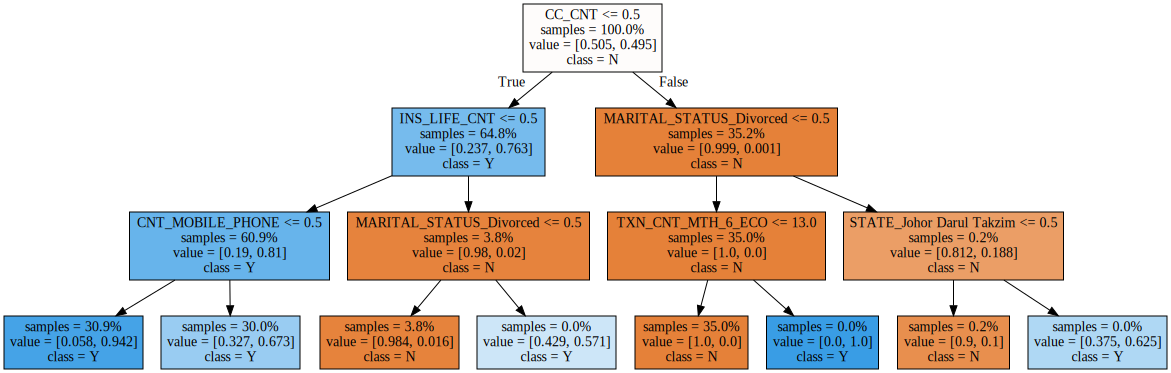

In [192]:
export_graphviz(dtc, out_file="tree.dot"
                ,class_names=["N", "Y"]
                ,feature_names=list(X)
                ,impurity=False
                ,filled=True
                ,proportion=True)

with open("tree.dot") as f:    
    dot_graph = f.read() 
graphviz.Source(dot_graph)